In [1]:
from scipy.io import loadmat
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss
from dstft import DSTFT, FDSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
mat = loadmat('../data/fan_flutter.mat')['x']
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

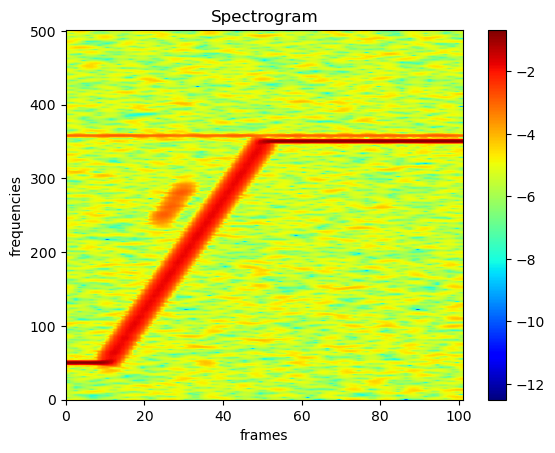

In [4]:
dstft = FDSTFT(x, win_length=500, support=1_000, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

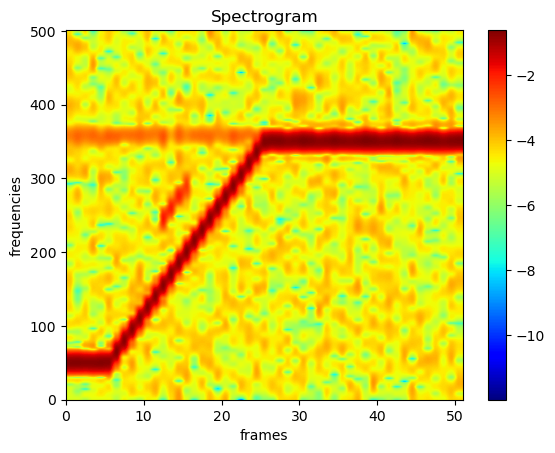

In [5]:
dstft = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

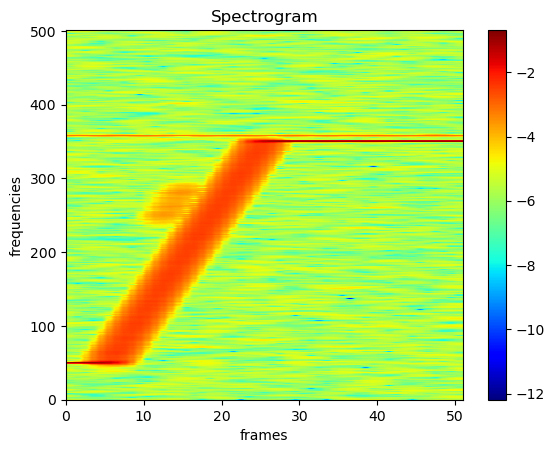

In [6]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

Single window length

236 tensor(9.4924, device='cuda:0')


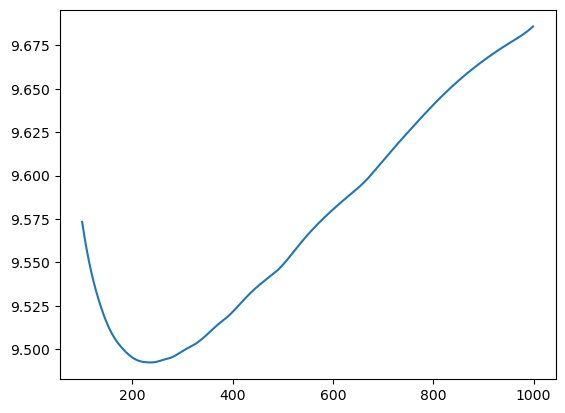

In [77]:
losses = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1_000, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    losses.append(err.cpu())
    
print(min_win, min_err)
plt.plot(range(100, 1000, 1), losses)

Epoch 00109: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00209: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00309: reducing learning rate of group 0 to 1.0000e-01.
308
235.4789276123047 tensor(9.4924, device='cuda:0', grad_fn=<MeanBackward0>)


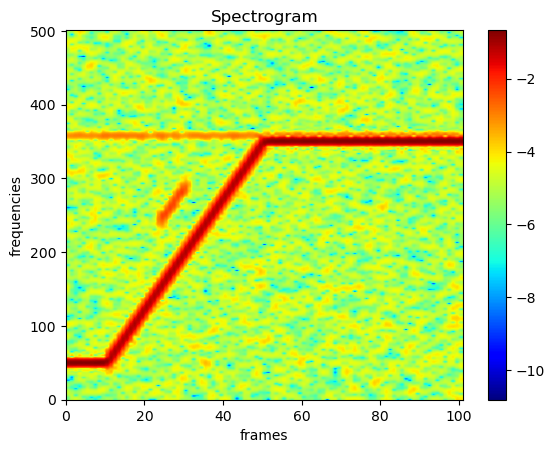

236.0


In [83]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
print(min_win, min_err)
dstft.print(spec, x, bar=True, wins=False, weights=False)
print(f'{dstft.win_length.item():.1f}')

(1, 20000)
(6000,)
(501, 120) (501, 120) (501,) (501,)
complex64 complex64 float32 float32


Text(0.5, 0, 'frames')

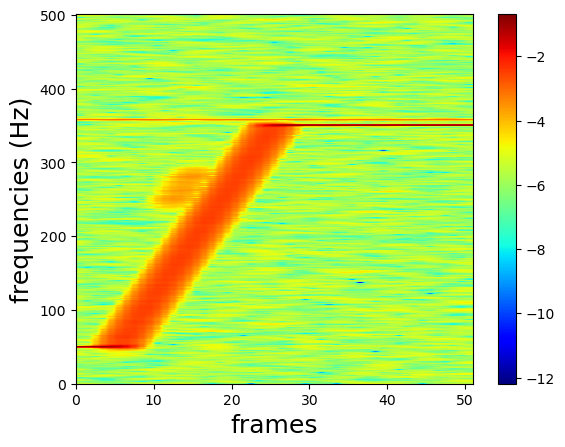

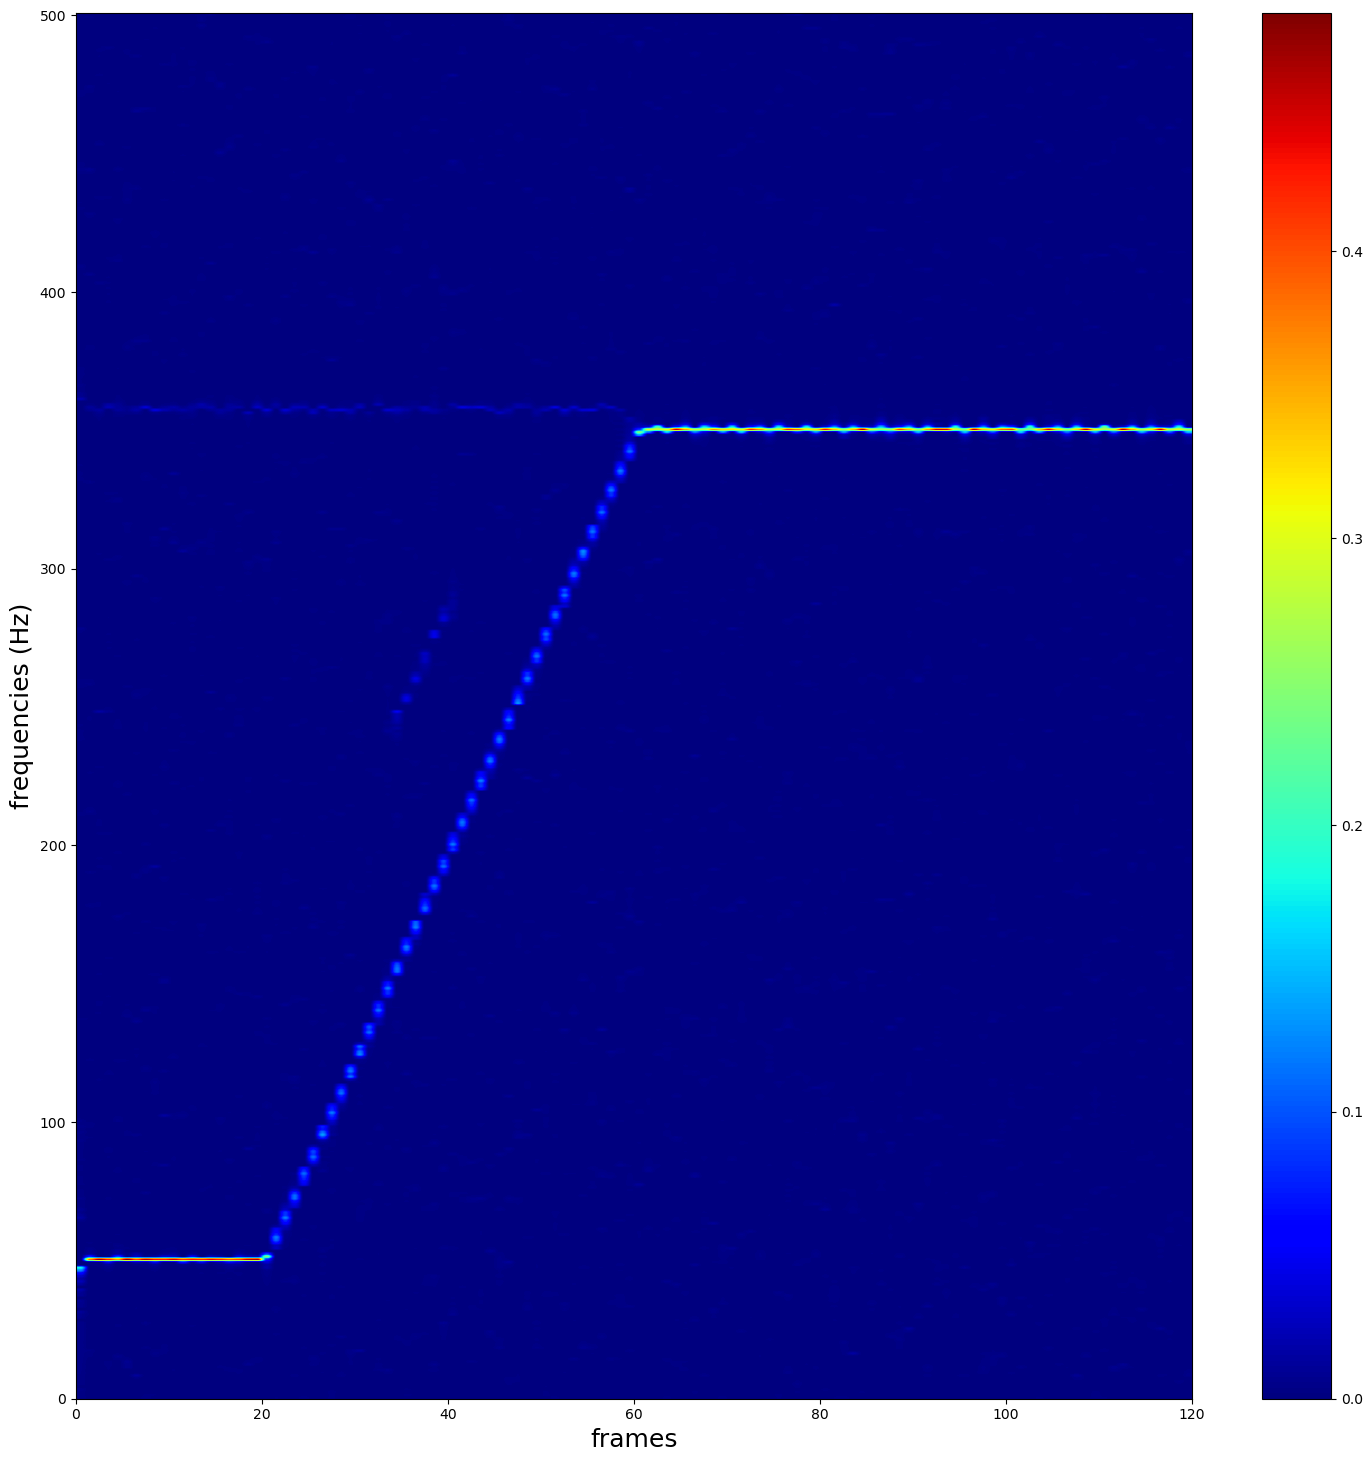

In [71]:
import ssqueezepy
import ssqueezepy.ssqueezing
from ssqueezepy import ssq_stft, ssqueeze
import matplotlib.pyplot as plt
#%matplotlib widget

# dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None, first_frame=True )
# spec, stft, real, imag, phase = dstft(x)

# phase += phase.max()

print(mat.shape)
mat2 = mat[0, 4_000:10_000]
print(mat2.shape)

Tsx, Sx, ssq_freqs_s, Sfs, *_    = ssq_stft(mat2, n_fft=1_000, win_len=1000, hop_len=50)

print(Tsx.shape, Sx.shape, ssq_freqs_s.shape, Sfs.shape)
print(Tsx.dtype, Sx.dtype, ssq_freqs_s.dtype, Sfs.dtype)

Sx = torch.from_numpy(Sx).abs().log().cpu()
SSQ = torch.from_numpy(Tsx).abs().cpu()

plt.figure()
ax = plt.subplot()
im = ax.imshow(spec[0].detach().log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0, spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

plt.figure(figsize=(18,18))
ax = plt.subplot()
im = ax.imshow(SSQ, aspect='auto', origin='lower', cmap='jet', extent=[0, SSQ.shape[-1], 0, SSQ.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18)

# SSQ, freqs = ssqueeze(spec.cpu().numpy(), w=phase.cpu().numpy(), scales='linear', ssq_freqs='linear', Sfs=range(1000), transform='stft', maprange='maximal')
# print(SSQ.shape, freqs.shape)

# plt.figure()
# ax = plt.subplot()
# im = ax.imshow(SSQ[0], aspect='auto', origin='lower', cmap='jet', extent=[0, SSQ.shape[-1], 0, SSQ.shape[-2]])
# plt.colorbar(im, ax=ax)
# plt.ylabel('frequencies (Hz)', fontsize=18)
# plt.xlabel('frames', fontsize=18)

Time-varying window length

Epoch 00034: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00044: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00054: reducing learning rate of group 0 to 1.0000e-01.
53


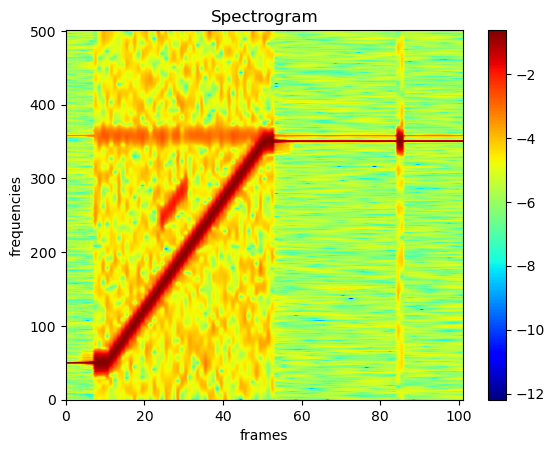

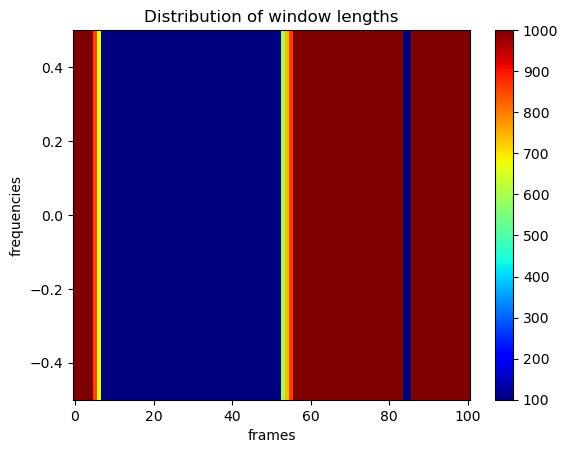

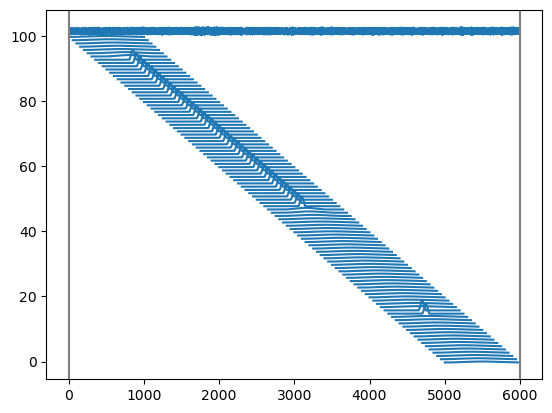

In [23]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Epoch 00044: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00054: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00064: reducing learning rate of group 0 to 1.0000e-01.
63


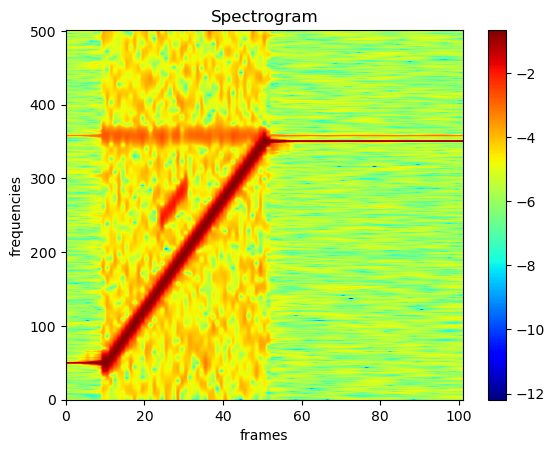

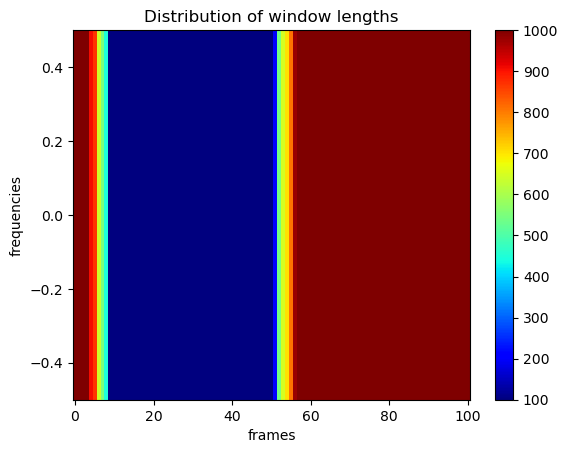

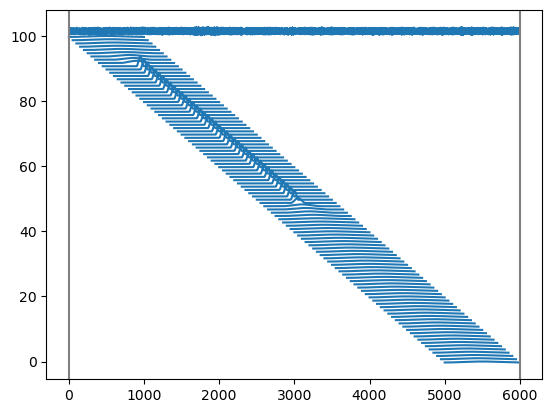

In [24]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True)

Frequency-varying window length

Epoch 00039: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00051: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00061: reducing learning rate of group 0 to 1.0000e-01.
60


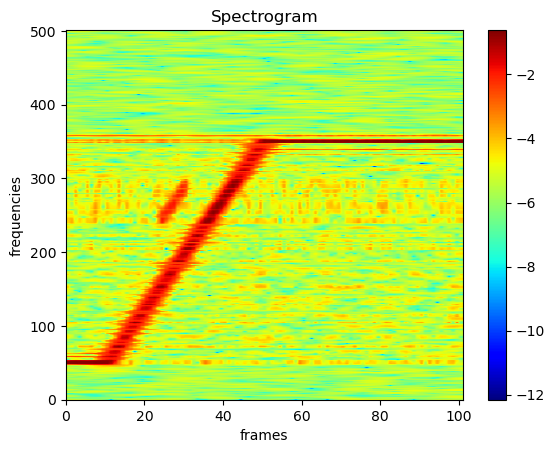

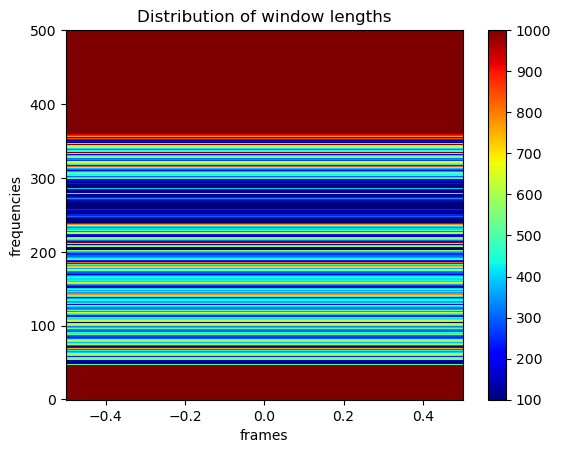

In [25]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)


Epoch 00062: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00105: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00119: reducing learning rate of group 0 to 1.0000e-01.
118


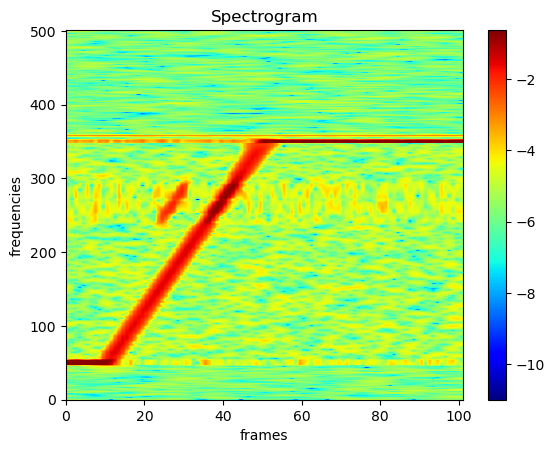

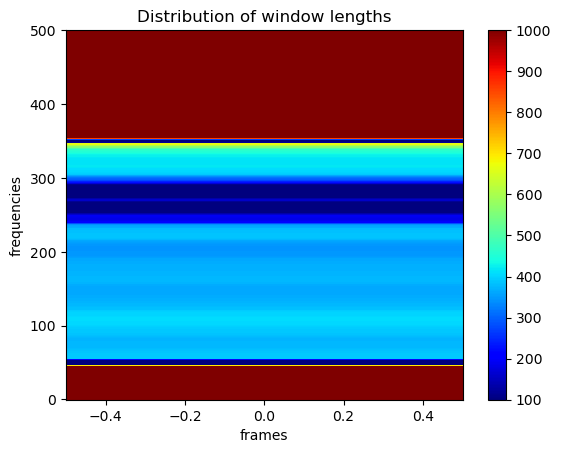

In [4]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.005 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Epoch 00012: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00126: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00160: reducing learning rate of group 0 to 1.0000e-01.
159


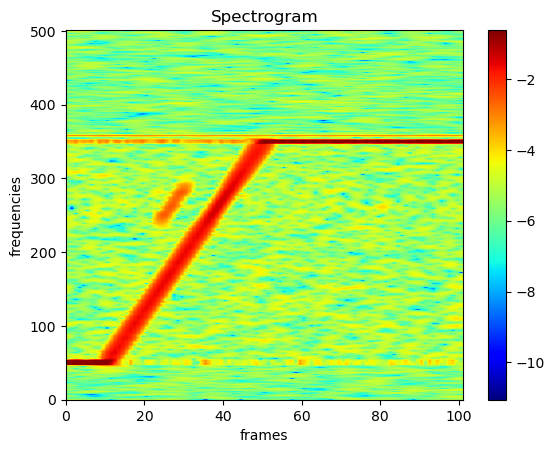

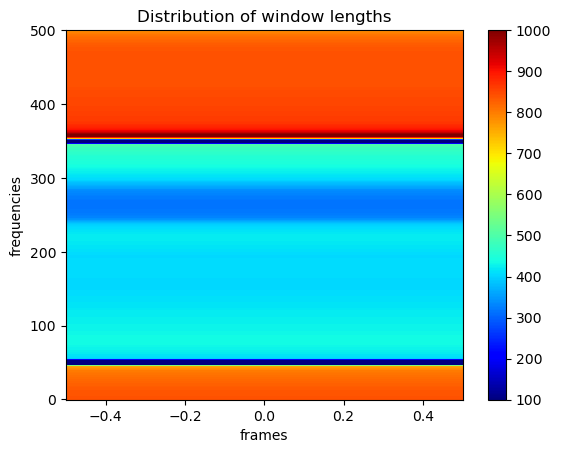

In [26]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Time-and-frequency-varying window length

Epoch 00065: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00085: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00095: reducing learning rate of group 0 to 1.0000e-01.
94


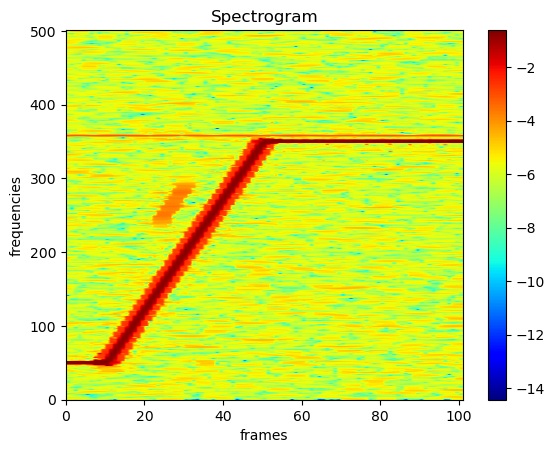

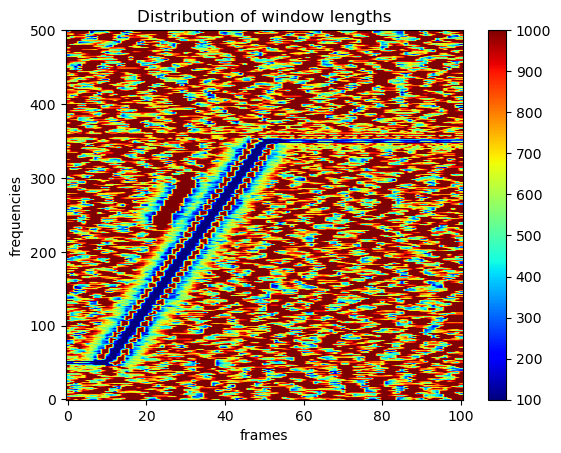

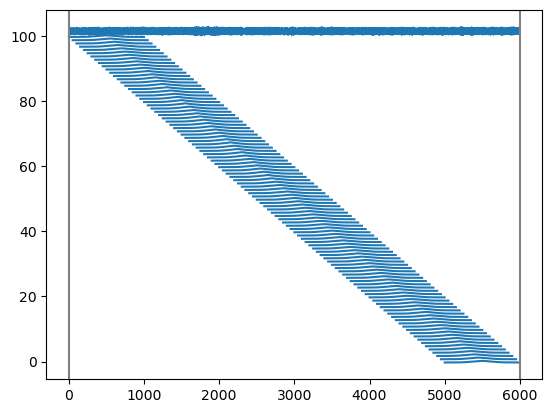

In [27]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Epoch 00112: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00112: reducing learning rate of group 1 to 1.0000e-01.
Epoch 00150: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00150: reducing learning rate of group 1 to 1.0000e-02.
Epoch 00174: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00174: reducing learning rate of group 1 to 1.0000e-03.
173


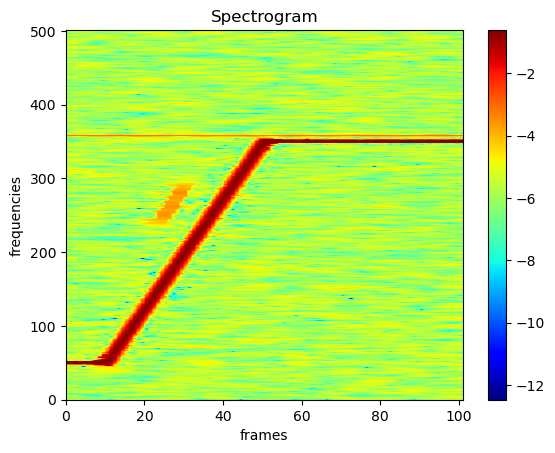

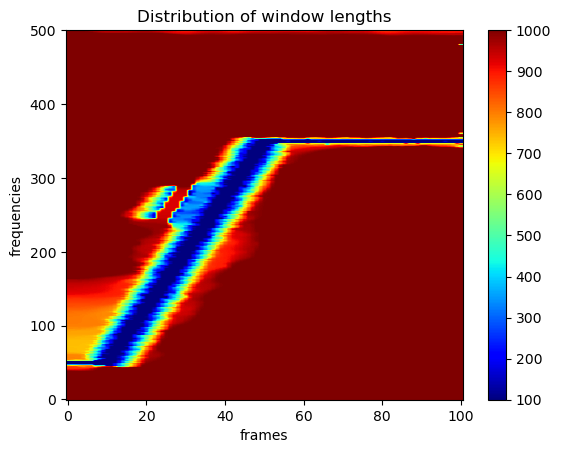

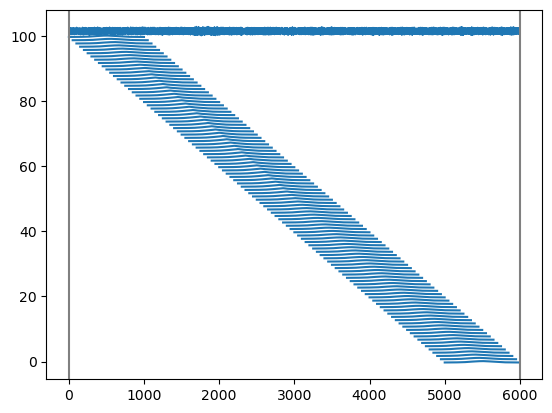

In [28]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)